# Research Notebook 

## The goal

The goal here is to understand the impact that data gaps have on the L01 pipeline. As seen, the impact of gaps on the telemetry variables result in a widening of the data gaps in the overall Michelson-like variables. I want to try and understand 

* What type of data gap is most impacted
* What generation of TDI is most impactful
* What do the data gap widening depend on? 
* Can I build a distribution of data gaps?

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
data_direc = "../data_for_simulations"
sys.path.append("../../artifacts_gen/gaps/")  # if gap_widening_utils.py is in the parent directory
from lisa_gap import GapMaskGenerator

sys.path.append("../utility_funcs/")

from gap_widening_utils import construct_mask_single_gap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up the instrument simulator

In [2]:
from lisaconstants import au
from lisaorbits import StaticConstellation

armlength = 2.5E9 # m
barycenter = [au, 0, 0] # m
orbits = StaticConstellation.from_armlengths(
    armlength, armlength, armlength, barycenter)

orbits.write("static_orbits.h5", mode = 'w')

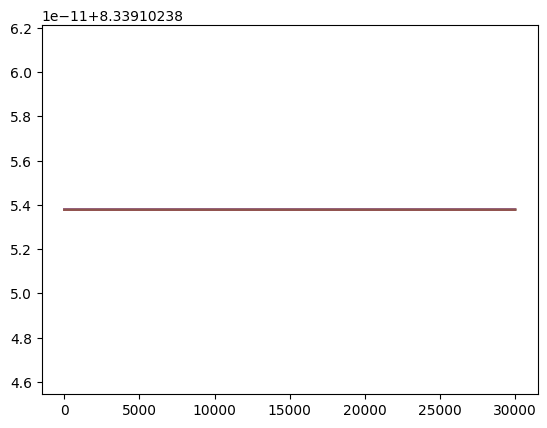

In [3]:
t = np.arange(0, 120_000*0.25,0.25)
for j in range(6):
    plt.plot(t, orbits.compute_ltt(t)[:,j], label=f"arm {j+1}")

In [ ]:
# Set up lolipops pipeline
from pathlib import Path
from lisainstrument import Instrument
import logging

simlen = 120_000

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('lisainstrument').setLevel(logging.INFO)
instr_static = Instrument(size=simlen, dt = 0.25, orbits = 'static_orbits.h5', seed=1234)

instr_static.disable_all_noises(excluding=['laser', 'test-mass', 'oms']) 
instr_static.simulate()

instr_static.write('static_short_simulation.h5', mode='w')
print("Length of simulation in time", simlen*0.25/60/60)

2025-07-23 09:19:43,308 - INFO - Initializing instrumental simulation
2025-07-23 09:19:43,311 - INFO - Computing measurement time vector (size=120000, dt=0.25)
2025-07-23 09:19:43,311 - INFO - Computing physics time vector (size=480000, dt=0.0625)
2025-07-23 09:19:43,313 - INFO - Computing telemetry time vector (size=2, dt=86400.0)
2025-07-23 09:19:43,321 - INFO - Using orbit file 'static_orbits.h5'
2025-07-23 09:19:43,812 - INFO - Using pre-defined locking configuration 'N1-12'
2025-07-23 09:19:43,812 - WARNING - Using default set of locking beatnote frequencies; this might cause interferometric beatnote frequencies to fall outside the requirement range of 5..25 MHz
2025-07-23 09:19:43,813 - INFO - Designing antialiasing filter ('kaiser', 240, 1.1, 2.9)
2025-07-23 09:19:43,813 - INFO - Starting simulation
2025-07-23 09:19:43,813 - INFO - Generating clock noise
2025-07-23 09:19:43,832 - INFO - Generating modulation noise
2025-07-23 09:19:43,833 - INFO - Generating backlink noise
2025-0

In [5]:
from pytdi import Data

from pytdi.michelson import compute_factorized_michelson

data = Data.from_instrument(instr_static)

2025-07-23 09:19:50,596 - INFO - Initializing combination with components '{'isi_12': [(1.0, [])], 'rfi_12': [(0.5, [])], 'rfi_21': [(0.5, ['D_12'])], 'tmi_12': [(-0.5, [])], 'tmi_21': [(-0.5, ['D_12'])]}'
2025-07-23 09:19:50,596 - INFO - Rotating combination '<pytdi.core.LISATDICombination object at 0x12f284950>' by 120 degrees
2025-07-23 09:19:50,597 - INFO - Transforming combination '<pytdi.core.LISATDICombination object at 0x12f284950>' with mapping '{1: 2, 2: 3, 3: 1}'
2025-07-23 09:19:50,597 - INFO - Rotating combination '<pytdi.core.LISATDICombination object at 0x12f1a9550>' by 120 degrees
2025-07-23 09:19:50,597 - INFO - Transforming combination '<pytdi.core.LISATDICombination object at 0x12f1a9550>' with mapping '{1: 2, 2: 3, 3: 1}'
2025-07-23 09:19:50,597 - INFO - Reflecting combination '<pytdi.core.LISATDICombination object at 0x12f284950>' around '1'
2025-07-23 09:19:50,597 - INFO - Transforming combination '<pytdi.core.LISATDICombination object at 0x12f284950>' with mappin

# Widening of the gap due to delays
## The $\eta$ variables

Now in the next cell we are going to verify our formula for the widening of the eta variables

In [6]:
measurement_values = data.MEASUREMENTS
ifos = data.measurements

mprs = data.delays
mpr_derivatives = data.delay_derivatives
MOSAS = data.MOSAS
dt = 1/data.fs

In [7]:
# I want to trim the mprs values by 1000 points at the start and end
N = 1000
mprs_trimmed = {}
for item in list(mprs.keys()):
    mprs_trimmed[item] = mprs[item][1000:-1000]

In [ ]:
def nanify_telemetry_variables(data, masking_function):
    """
    Apply a masking function (with NaNs) to telemetry variables, pseudo-ranges, and their derivatives.

    Args:
        data (object): Telemetry object with .ifos attribute (dict-like).
        masking_function (np.ndarray): Array of 1s and NaNs to apply as a mask.

    Returns:
        tuple: (telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans)
            telemetry_w_gaps: telemetry object with masked .ifos fields
            mprs_w_nans: dict of masked pseudo-ranges
            mpr_derivatives_w_nans: dict of masked pseudo-range derivatives
        telemetry (object): Telemetry object with .ifos attribute (dict-like).
        mprs (dict): Dictionary of pseudo-range arrays, keyed by MOSA.
        mpr_derivatives (dict): Dictionary of pseudo-range derivative arrays, keyed by MOSA.
        masking_function (np.ndarray): Array of 1s and NaNs to apply as a mask.

    Returns:
        tuple: (telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans)
            telemetry_w_gaps: telemetry object with masked .ifos fields
            mprs_w_nans: dict of masked pseudo-ranges
            mpr_derivatives_w_nans: dict of masked pseudo-range derivatives
    """
    import copy

    # Deep copy to avoid modifying original data
    MOSAS = data.MOSAS
    data_w_gaps = copy.deepcopy(data)

    # Build label lists for all relevant telemetry fields
    tmi_label = [f"tmi_{mosa}" for mosa in MOSAS]
    rfi_label = [f"rfi_{mosa}" for mosa in MOSAS]
    rfi_sb_label = [f"rfi_sb_{mosa}" for mosa in MOSAS]
    isi_label = [f"isi_{mosa}" for mosa in MOSAS]
    isi_sb_label = [f"isi_sb_{mosa}" for mosa in MOSAS]

    # Apply mask to all telemetry fields
    for tmi_item, rfi_item, rfi_sb_item, isi_item, isi_sb_item in zip(
        tmi_label, rfi_label, rfi_sb_label, isi_label, isi_sb_label
    ):
        data_w_gaps.measurements[tmi_item] = data.measurements[tmi_item] * masking_function
        data_w_gaps.measurements[rfi_item] = data.measurements[rfi_item] * masking_function
        data_w_gaps.measurements[rfi_sb_item] = data.measurements[rfi_sb_item] * masking_function
        data_w_gaps.measurements[isi_item] = data.measurements[isi_item] * masking_function
        data_w_gaps.measurements[isi_sb_item] = data.measurements[isi_sb_item] * masking_function

    # Deep copy and mask pseudo-ranges and their derivatives
    for delay_craft in list(data.delays.keys()):
        data_w_gaps.delays[delay_craft] = masking_function * data.delays[delay_craft]
        data_w_gaps.delay_derivatives[delay_craft] = masking_function * data.delay_derivatives[delay_craft]

    return data_w_gaps 

Lost out on approximately 0.6944444444444444 hours of data
This ammounts to 10000 number of samples


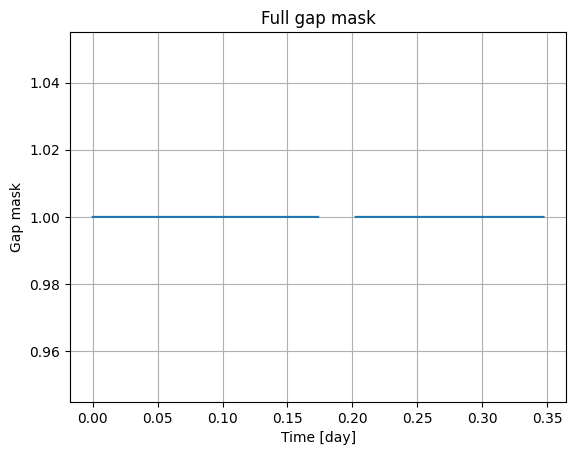

In [32]:
# Construct gap class

CONTROL_NANS = True
GAP_CLASS = False

sim_t = np.arange(0, simlen * dt, dt)


N_tel_nans= 10000

masking_function = construct_mask_single_gap(N_tel_nans, length = simlen)


plt.plot(sim_t / 60 / 60 / 24, masking_function)
plt.title("Full gap mask")
plt.xlabel("Time [day]")
plt.ylabel("Gap mask")
plt.grid(True)

print(
    "Lost out on approximately",
    np.sum(np.isnan(masking_function)) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(np.sum(np.isnan(masking_function)))
)

In [33]:
from pytdi.intervar import compute_etas

N_nans = 10000
order = 27
masking_function = construct_mask_single_gap(N_nans, length = simlen)
data_w_gaps = nanify_telemetry_variables(data, masking_function)
etas_w_gaps_nans = compute_etas(data_w_gaps, order, unit = "frequency")

N_nans_in_data = np.sum(np.isnan(data_w_gaps.measurements["tmi_12"]))
print("Number of nans in data", N_nans_in_data)
N_nans_in_eta_pytdi = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
widening_gap_eta_pytdi = N_nans_in_eta_pytdi - N_nans
print("Number of nans in the eta variables = ", N_nans_in_eta_pytdi)
print("Overall widening of gap in eta variables = ", widening_gap_eta_pytdi)

2025-07-23 09:35:43,000 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1d1e20>'
2025-07-23 09:35:43,001 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1d1e20>'


2025-07-23 09:35:43,056 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1de270>'
2025-07-23 09:35:43,057 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1de270>'
2025-07-23 09:35:43,103 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1b3ec0>'
2025-07-23 09:35:43,103 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1b3ec0>'
2025-07-23 09:35:43,152 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1b3200>'
2025-07-23 09:35:43,152 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1b3200>'
2025-07-23 09:35:43,184 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1de0f0>'
2025-07-23 09:35:43,185 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1de0f0>'
2025-07-23 09:35:43,215 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1dc800>'
2025-07-23

Number of nans in data 10000
Number of nans in the eta variables =  10047
Overall widening of gap in eta variables =  47


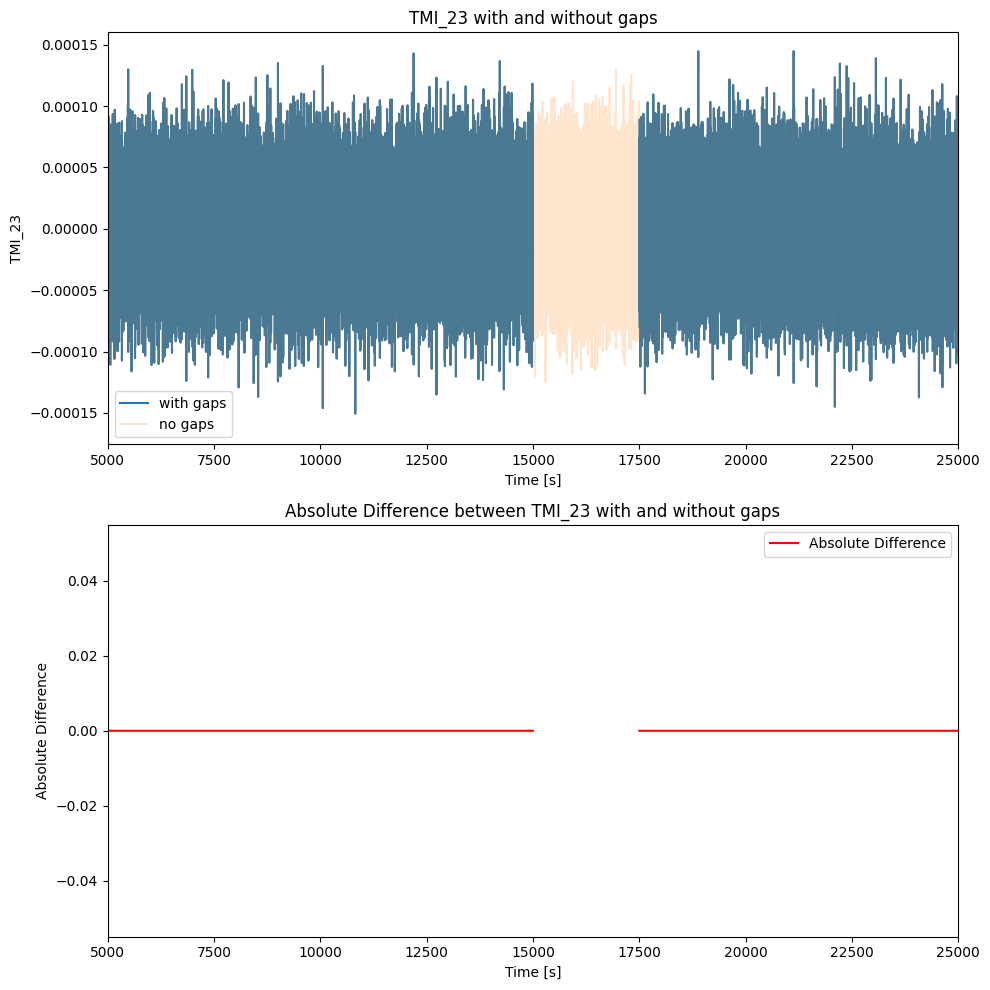

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0]
idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]
# First subplot: Original plot with gaps and no gaps
j = 10000
axs[0].plot(sim_t, data_w_gaps.measurements["tmi_23"], label="with gaps", alpha=1)
axs[0].plot(sim_t, data.measurements["tmi_23"], label="no gaps", alpha=0.2)
axs[0].set_xlim([sim_t[idx_start_gap] - j, sim_t[idx_start_gap] + j])
axs[0].set_ylabel(r"TMI_23")
# axs[0].set_ylim([-4100, -3200])
axs[0].set_xlabel("Time [s]")
axs[0].legend()
axs[0].set_title("TMI_23 with and without gaps")

# Second subplot: Absolute difference between the two
absolute_difference = np.abs(data_w_gaps.measurements["tmi_23"] - data.measurements["tmi_23"])
axs[1].plot(sim_t, absolute_difference, label="Absolute Difference", color="red")
axs[1].set_xlim([sim_t[idx_start_gap] - j, sim_t[idx_start_gap] + j])
axs[1].set_ylabel("Absolute Difference")
axs[1].set_xlabel("Time [s]")
axs[1].legend()
axs[1].set_title("Absolute Difference between TMI_23 with and without gaps")

plt.tight_layout()
plt.show()

In [35]:
from scipy.signal import lombscargle, welch
import numpy as np
import matplotlib.pyplot as plt

# Extract data and parameters
tmi_23_original = data.measurements["tmi_23"]
tmi_23_with_gaps = data_w_gaps.measurements["tmi_23"]
fs = data.fs
dt = 1/fs

# Create time vector
time_vector = sim_t

# For Lomb-Scargle: remove NaN values but keep track of corresponding times
valid_mask = ~np.isnan(tmi_23_with_gaps)
clean_data = tmi_23_with_gaps[valid_mask]
clean_times = time_vector[valid_mask]

print(f"Original data length: {len(tmi_23_original)} samples")
print(f"Data with gaps (valid points): {len(clean_data)} samples")
print(f"Percentage of data lost: {100*(1 - len(clean_data)/len(tmi_23_original)):.2f}%")

# Define frequency grid for Lomb-Scargle
nyquist = 0.5 * fs
frequencies_ls = np.logspace(-4, np.log10(nyquist), 2000)  # From 1e-4 to Nyquist
angular_frequencies = 2 * np.pi * frequencies_ls

# Compute Lomb-Scargle periodogram for gapped data
pgram_gaps = lombscargle(clean_times, clean_data, angular_frequencies, normalize=True)

# Compute Welch PSD for original data (no gaps)
freq_welch, psd_welch = welch(
    tmi_23_original, 
    fs=fs, 
    window='hann',
    nperseg=8192,
    noverlap=4096,
    scaling='density'
)

# Convert Lomb-Scargle result to power spectral density units
# (Lomb-Scargle gives normalized power, convert to match Welch scaling)
pgram_gaps_scaled = pgram_gaps * np.var(clean_data) * len(clean_data) / fs

Original data length: 120000 samples
Data with gaps (valid points): 110000 samples
Percentage of data lost: 8.33%


(0.5, 4.0)

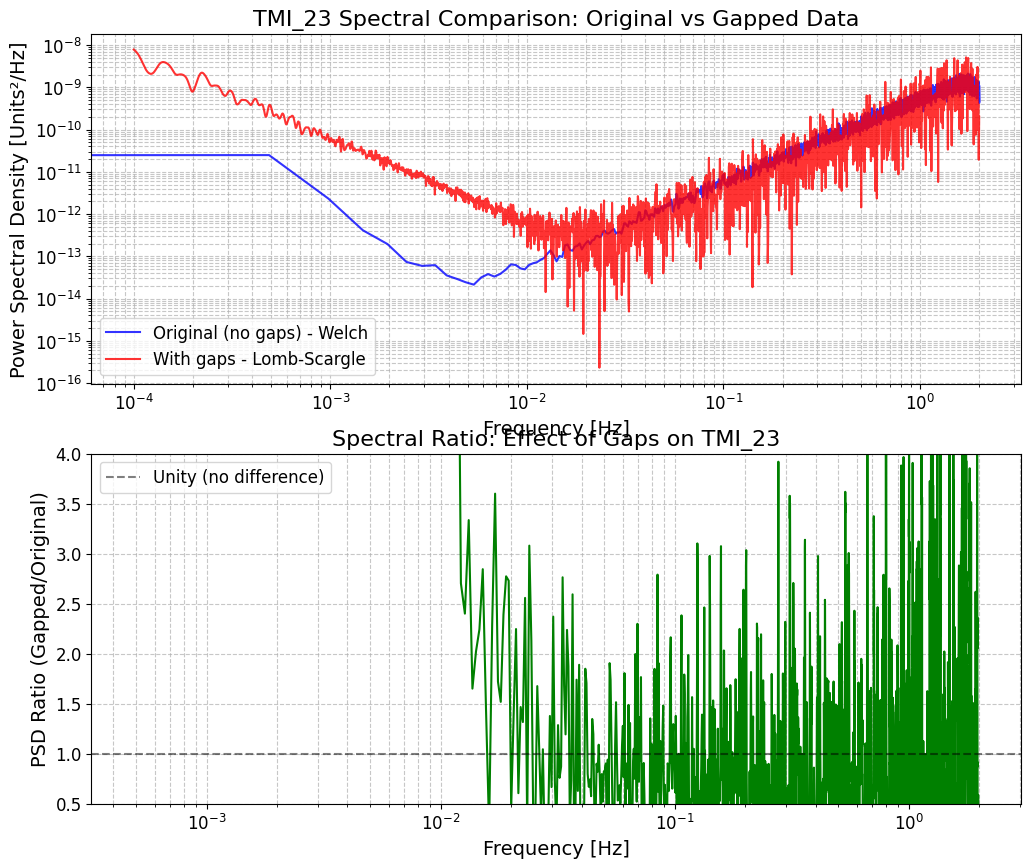

In [36]:
# Create comparison plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Direct comparison of PSDs
ax1.loglog(freq_welch, psd_welch, label='Original (no gaps) - Welch', 
           linewidth=1.5, alpha=0.8, color='blue')
ax1.loglog(frequencies_ls, pgram_gaps_scaled, label='With gaps - Lomb-Scargle', 
           linewidth=1.5, alpha=0.8, color='red')
ax1.set_xlabel('Frequency [Hz]', fontsize=14)
ax1.set_ylabel('Power Spectral Density [Units²/Hz]', fontsize=14)
ax1.set_title('TMI_23 Spectral Comparison: Original vs Gapped Data', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, which="both", linestyle="--", alpha=0.7)
ax1.tick_params(axis="both", which="major", labelsize=12)

# Plot 2: Ratio of PSDs (to highlight differences)
# Interpolate Lomb-Scargle result to Welch frequency grid for comparison
from scipy.interpolate import interp1d
interp_func = interp1d(frequencies_ls, pgram_gaps_scaled, 
                       bounds_error=False, fill_value=np.nan, kind='linear')
pgram_interp = interp_func(freq_welch)

# Calculate ratio where both are valid
valid_ratio = ~np.isnan(pgram_interp) & (pgram_interp > 0) & (psd_welch > 0)
ratio = np.full_like(freq_welch, np.nan)
ratio[valid_ratio] = pgram_interp[valid_ratio] / psd_welch[valid_ratio]

ax2.semilogx(freq_welch[valid_ratio], ratio[valid_ratio], 
             linewidth=1.5, color='green')
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Unity (no difference)')
ax2.set_xlabel('Frequency [Hz]', fontsize=14)
ax2.set_ylabel('PSD Ratio (Gapped/Original)', fontsize=14)
ax2.set_title('Spectral Ratio: Effect of Gaps on TMI_23', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, which="both", linestyle="--", alpha=0.7)
ax2.tick_params(axis="both", which="major", labelsize=12)
ax2.set_ylim([0.5, 4.0])  # Focus on deviations from unity



In [37]:
plt.tight_layout()
plt.show()

# Print some statistics about the spectral differences
print(f"\nSpectral Analysis Summary:")
print(f"Frequency range (Welch): {freq_welch[1]:.6f} to {freq_welch[-1]:.3f} Hz")
print(f"Frequency range (Lomb-Scargle): {frequencies_ls[0]:.6f} to {frequencies_ls[-1]:.3f} Hz")

# Calculate RMS difference in overlapping frequency range
overlap_mask = (freq_welch >= frequencies_ls[0]) & (freq_welch <= frequencies_ls[-1])
if np.sum(overlap_mask) > 0:
    ratio_rms = np.sqrt(np.nanmean((ratio[overlap_mask] - 1)**2))
    print(f"RMS deviation from unity in ratio: {ratio_rms:.4f}")
    print(f"Mean ratio (should be ~1 if spectra match): {np.nanmean(ratio[overlap_mask]):.4f}")

<Figure size 640x480 with 0 Axes>


Spectral Analysis Summary:
Frequency range (Welch): 0.000488 to 2.000 Hz
Frequency range (Lomb-Scargle): 0.000100 to 2.000 Hz
RMS deviation from unity in ratio: 5.6713
Mean ratio (should be ~1 if spectra match): 1.3428


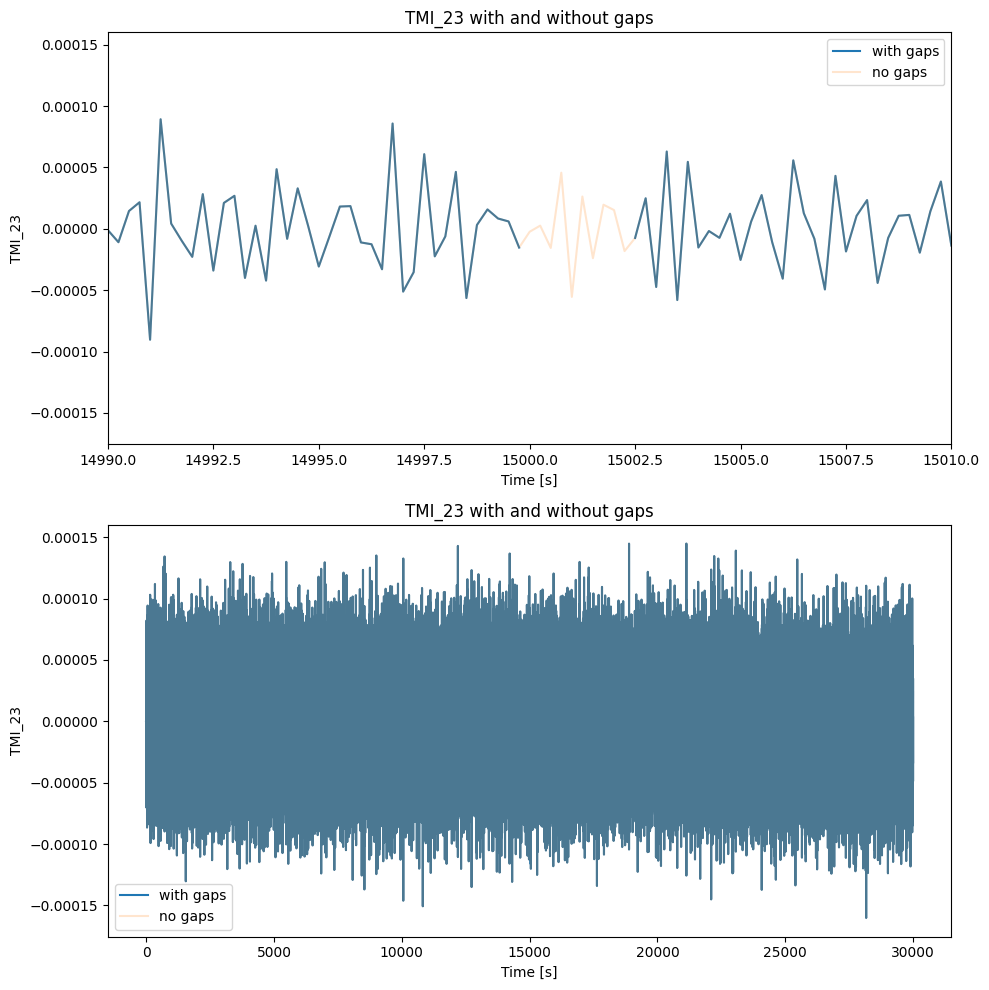

In [59]:
# Compute eta variables for both original data and data with gaps
from pytdi.intervar import compute_etas
from pytdi.michelson import compute_factorized_michelson

N_tel_nans= 10

masking_function = construct_mask_single_gap(N_tel_nans, length = simlen)

data_w_gaps = nanify_telemetry_variables(data, masking_function)
# Set order for computations
order = 45

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0]
idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]
# First subplot: Original plot with gaps and no gaps
j = 10
axs[0].plot(sim_t, data_w_gaps.measurements["tmi_23"], label="with gaps", alpha=1)
axs[0].plot(sim_t, data.measurements["tmi_23"], label="no gaps", alpha=0.2)
axs[0].set_xlim([sim_t[idx_start_gap] - j, sim_t[idx_start_gap] + j])
axs[0].set_ylabel(r"TMI_23")
# axs[0].set_ylim([-4100, -3200])
axs[0].set_xlabel("Time [s]")
axs[0].legend()
axs[0].set_title("TMI_23 with and without gaps")

# Second subplot: Absolute difference between the two
axs[1].plot(sim_t, data_w_gaps.measurements["tmi_23"], label="with gaps", alpha=1)
axs[1].plot(sim_t, data.measurements["tmi_23"], label="no gaps", alpha=0.2)
axs[1].set_ylabel(r"TMI_23")
# ax1[0].set_ylim([-4100, -3200])
axs[1].set_xlabel("Time [s]")
axs[1].legend()
axs[1].set_title("TMI_23 with and without gaps")

plt.tight_layout()
plt.show()

In [60]:

order = 45

# Compute eta variables for original data (no gaps)
etas_original = compute_etas(data, order, unit="frequency")


# Compute second generation TDI variables for original data
tdi_gen2_original = compute_factorized_michelson(
    data, etas=etas_original, rot=0, order=order, generation=2
)

# Compute eta variables for data with gaps
etas_w_gaps = compute_etas(data_w_gaps, order, unit="frequency")

# Compute second generation TDI variables for data with gaps
tdi_gen2_w_gaps = compute_factorized_michelson(
    data_w_gaps, etas=etas_w_gaps, rot=0, order=order, generation=2
)

print("Original data TDI-2 variables computed:")
print(f"X channel shape: {tdi_gen2_original.shape}")
print(f"Number of NaNs in original X: {np.sum(np.isnan(tdi_gen2_original))}")

print("\nData with gaps TDI-2 variables computed:")
print(f"X channel shape: {tdi_gen2_w_gaps.shape}")
print(f"Number of NaNs in gapped X: {np.sum(np.isnan(tdi_gen2_w_gaps))}")

# Calculate the widening effect
original_gap_count = np.sum(np.isnan(masking_function))
tdi_gap_count = np.sum(np.isnan(tdi_gen2_w_gaps))
gap_widening = tdi_gap_count - original_gap_count

print(f"\nGap widening analysis:")
print(f"Original gaps in telemetry: {original_gap_count}")
print(f"Total gaps in TDI-2 X: {tdi_gap_count}")
print(f"Gap widening factor: {gap_widening}")
print(f"Widening ratio: {gap_widening/original_gap_count:.2f}")

2025-07-23 09:55:00,557 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1d1e20>'
2025-07-23 09:55:00,557 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1d1e20>'


2025-07-23 09:55:00,685 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1de270>'
2025-07-23 09:55:00,685 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1de270>'
2025-07-23 09:55:00,799 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1b3ec0>'
2025-07-23 09:55:00,800 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1b3ec0>'
2025-07-23 09:55:00,912 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1b3200>'
2025-07-23 09:55:00,913 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1b3200>'
2025-07-23 09:55:00,986 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1de0f0>'
2025-07-23 09:55:00,987 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1de0f0>'
2025-07-23 09:55:01,065 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1dc800>'
2025-07-23

Original data TDI-2 variables computed:
X channel shape: (120000,)
Number of NaNs in original X: 0

Data with gaps TDI-2 variables computed:
X channel shape: (120000,)
Number of NaNs in gapped X: 366

Gap widening analysis:
Original gaps in telemetry: 10
Total gaps in TDI-2 X: 366
Gap widening factor: 356
Widening ratio: 35.60


In [61]:
from scipy.signal import welch, lombscargle

# Welch PSD for TDI2 X (no gaps)
freq_welch_tdi2, psd_welch_tdi2 = welch(
    tdi_gen2_original,
    fs=fs,
    window='hann',
    nperseg=8192,
    noverlap=4096,
    scaling='density'
)

# Remove NaNs from gapped TDI2 X
valid_mask_tdi2 = ~np.isnan(tdi_gen2_w_gaps)
tdi2_gapped_clean = tdi_gen2_w_gaps[valid_mask_tdi2]
tdi2_gapped_times = sim_t[valid_mask_tdi2]

# Lomb-Scargle for gapped TDI2 X
nyquist_tdi2 = 0.5 * fs
frequencies_ls_tdi2 = np.logspace(-4, np.log10(nyquist_tdi2), 2000)
angular_frequencies_tdi2 = 2 * np.pi * frequencies_ls_tdi2
pgram_tdi2_gaps = lombscargle(tdi2_gapped_times, tdi2_gapped_clean, angular_frequencies_tdi2, normalize=True)
# Normalise to match Welch scaling
pgram_tdi2_gaps_scaled = pgram_tdi2_gaps * np.var(tdi2_gapped_clean) * len(tdi2_gapped_clean) / fs


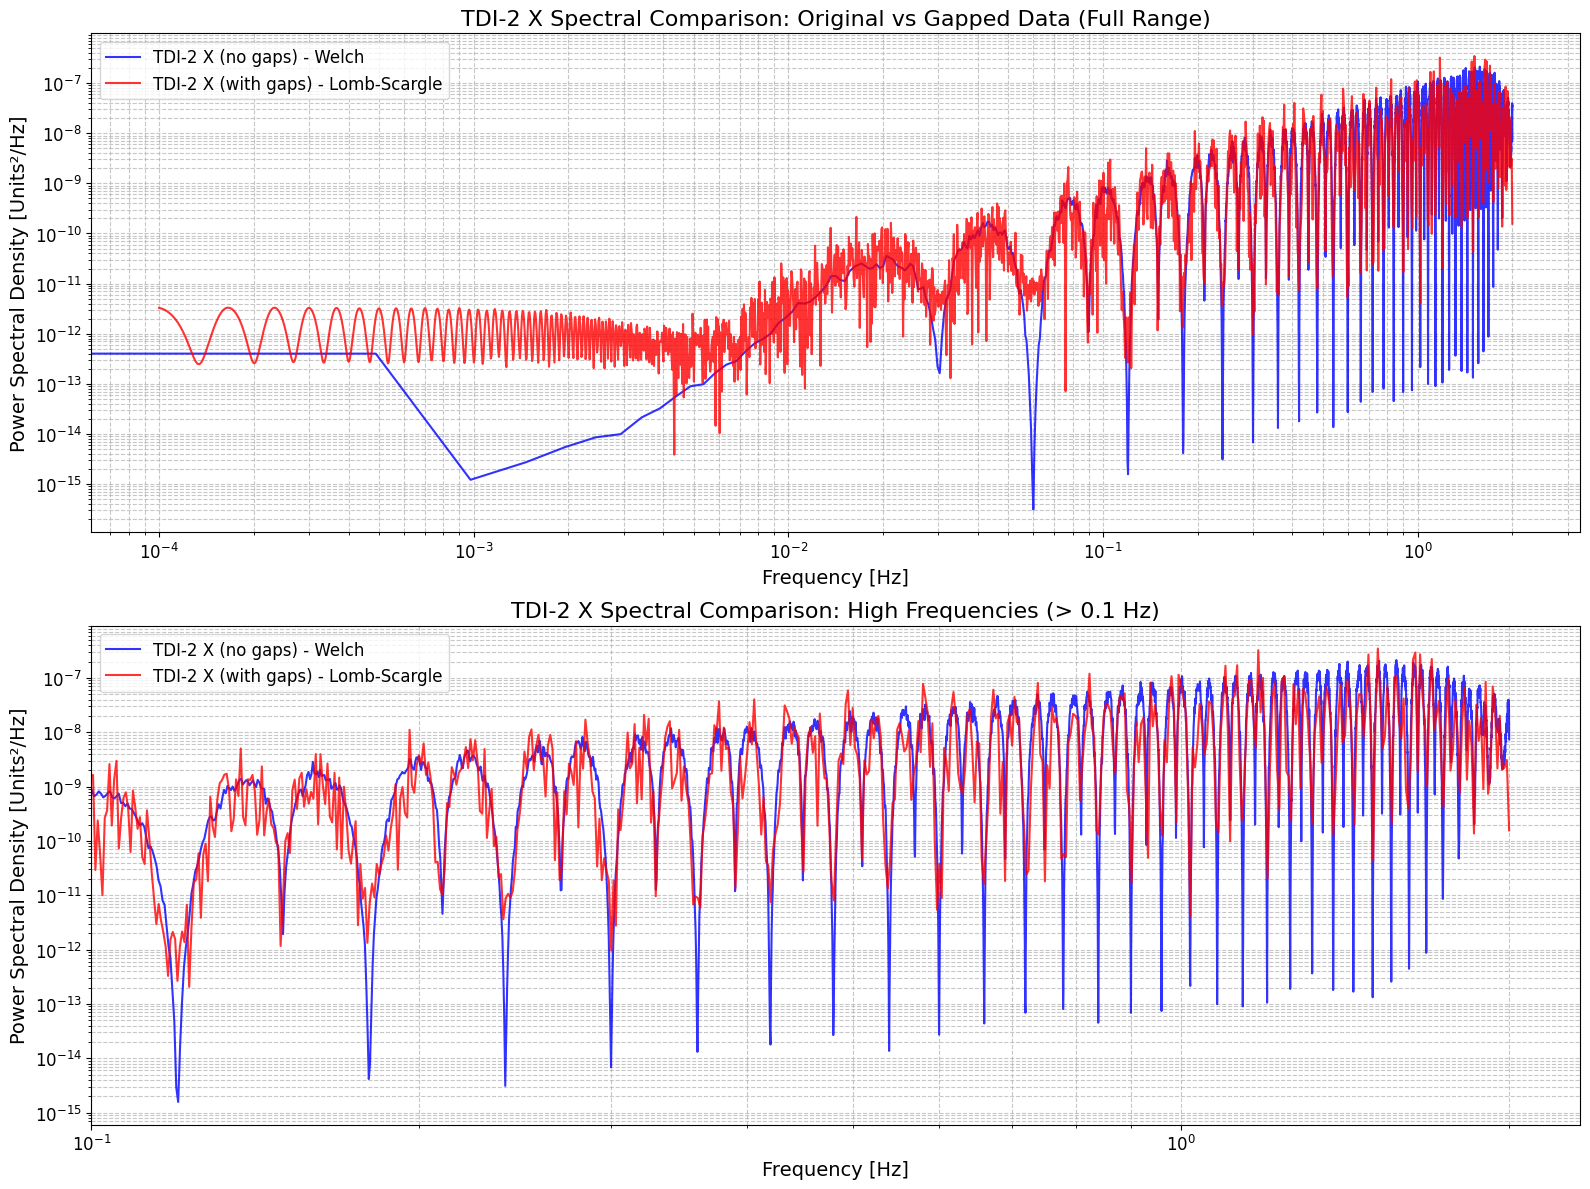


High-Frequency Analysis (> 0.1 Hz):
Welch points above 0.1 Hz: 3892
Lomb-Scargle points above 0.1 Hz: 605
Mean power (Welch, > 0.1 Hz): 2.841394e-08
Mean power (Lomb-Scargle, > 0.1 Hz): 1.389447e-08
High-frequency power ratio (Gapped/Original): 0.4890


In [63]:
# Create comparison plot for TDI-2 X periodograms with high-frequency zoom
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Direct comparison of PSDs for TDI-2 X (full frequency range)
ax1.loglog(freq_welch_tdi2, psd_welch_tdi2, label='TDI-2 X (no gaps) - Welch', 
           linewidth=1.5, alpha=0.8, color='blue')
ax1.loglog(frequencies_ls_tdi2, pgram_tdi2_gaps_scaled, label='TDI-2 X (with gaps) - Lomb-Scargle', 
           linewidth=1.5, alpha=0.8, color='red')
ax1.set_xlabel('Frequency [Hz]', fontsize=14)
ax1.set_ylabel('Power Spectral Density [Units²/Hz]', fontsize=14)
ax1.set_title('TDI-2 X Spectral Comparison: Original vs Gapped Data (Full Range)', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, which="both", linestyle="--", alpha=0.7)
ax1.tick_params(axis="both", which="major", labelsize=12)

# Plot 2: Zoomed view for high frequencies (> 0.1 Hz)
freq_mask_welch = freq_welch_tdi2 > 0.1
freq_mask_ls = frequencies_ls_tdi2 > 0.1

ax2.loglog(freq_welch_tdi2[freq_mask_welch], psd_welch_tdi2[freq_mask_welch], 
           label='TDI-2 X (no gaps) - Welch', linewidth=1.5, alpha=0.8, color='blue')
ax2.loglog(frequencies_ls_tdi2[freq_mask_ls], pgram_tdi2_gaps_scaled[freq_mask_ls], 
           label='TDI-2 X (with gaps) - Lomb-Scargle', linewidth=1.5, alpha=0.8, color='red')
ax2.set_xlabel('Frequency [Hz]', fontsize=14)
ax2.set_ylabel('Power Spectral Density [Units²/Hz]', fontsize=14)
ax2.set_title('TDI-2 X Spectral Comparison: High Frequencies (> 0.1 Hz)', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, which="both", linestyle="--", alpha=0.7)
ax2.tick_params(axis="both", which="major", labelsize=12)
ax2.set_xlim([0.1, None])  # Set minimum frequency to 0.1 Hz

plt.tight_layout()
plt.show()

# Print statistics about high-frequency behavior
print(f"\nHigh-Frequency Analysis (> 0.1 Hz):")
print(f"Welch points above 0.1 Hz: {np.sum(freq_mask_welch)}")
print(f"Lomb-Scargle points above 0.1 Hz: {np.sum(freq_mask_ls)}")

if np.sum(freq_mask_welch) > 0 and np.sum(freq_mask_ls) > 0:
    # Calculate mean power in high-frequency range
    mean_power_welch_hf = np.mean(psd_welch_tdi2[freq_mask_welch])
    mean_power_ls_hf = np.mean(pgram_tdi2_gaps_scaled[freq_mask_ls])
    
    print(f"Mean power (Welch, > 0.1 Hz): {mean_power_welch_hf:.6e}")
    print(f"Mean power (Lomb-Scargle, > 0.1 Hz): {mean_power_ls_hf:.6e}")
    print(f"High-frequency power ratio (Gapped/Original): {mean_power_ls_hf/mean_power_welch_hf:.4f}")

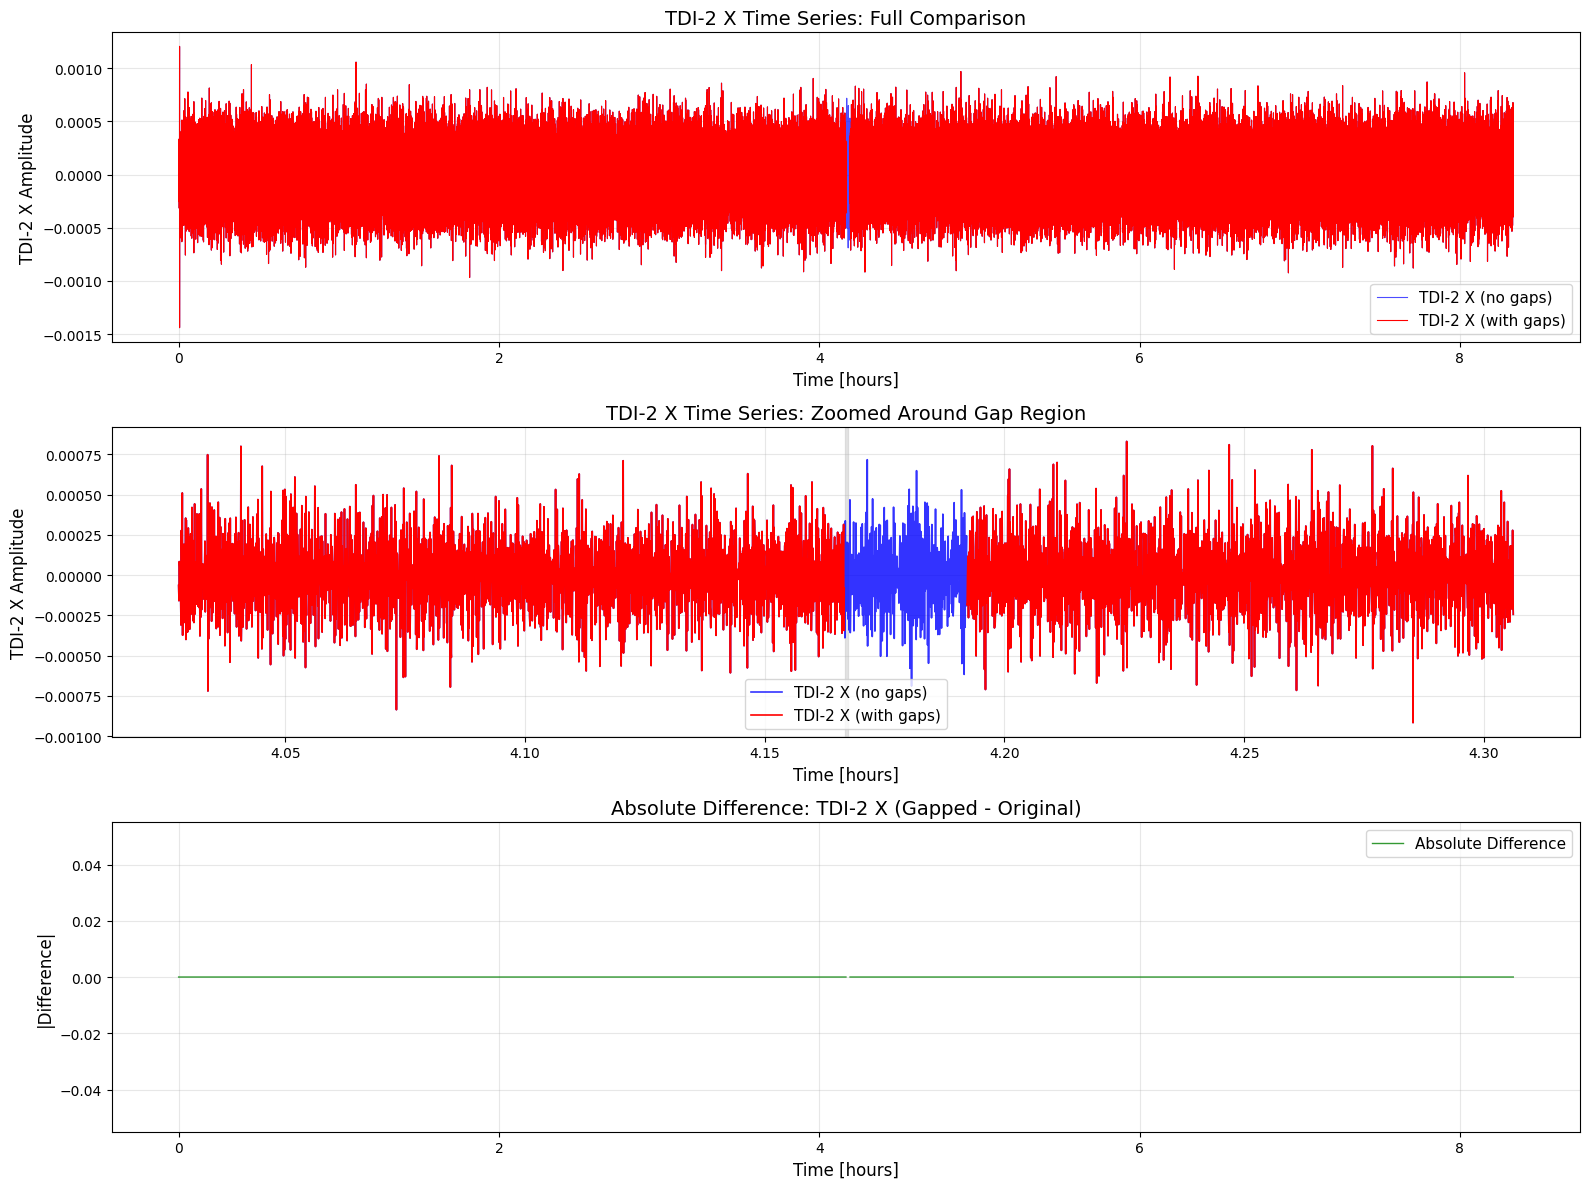


TDI-2 X Time Domain Analysis:
Original TDI-2 X RMS: 2.320482e-04
Gapped TDI-2 X RMS (excluding NaNs): 2.320485e-04
Maximum absolute difference: 0.000000e+00
RMS of difference: 0.000000e+00
Mean absolute difference: 0.000000e+00

Gap Analysis:
Original gap duration: 0.001 hours
TDI-2 gap duration: 0.025 hours
Gap amplification factor: 36.60
RMS difference in non-gap regions: 0.000000e+00


In [66]:
# Look at the difference of the two TDI expressions

# Plot TDI-2 X time series comparison
fig, axs = plt.subplots(3, 1, figsize=(16, 12))

# Find gap locations for zoomed view
idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0] 
idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]

# Plot 1: Full time series comparison
axs[0].plot(sim_t / 3600, tdi_gen2_original, label="TDI-2 X (no gaps)", 
            alpha=0.7, linewidth=0.8, color='blue')
axs[0].plot(sim_t / 3600, tdi_gen2_w_gaps, label="TDI-2 X (with gaps)", 
            alpha=1.0, linewidth=0.8, color='red')
axs[0].set_ylabel('TDI-2 X Amplitude', fontsize=12)
axs[0].set_xlabel('Time [hours]', fontsize=12)
axs[0].set_title('TDI-2 X Time Series: Full Comparison', fontsize=14)
axs[0].legend(fontsize=11)
axs[0].grid(True, alpha=0.3)

# Plot 2: Zoomed view around the gap
zoom_window = 2000  # samples around gap
start_zoom = max(0, idx_start_gap - zoom_window)
end_zoom = min(len(sim_t), idx_end_gap + zoom_window)

axs[1].plot(sim_t[start_zoom:end_zoom] / 3600, 
            tdi_gen2_original[start_zoom:end_zoom], 
            label="TDI-2 X (no gaps)", alpha=0.8, linewidth=1.2, color='blue')
axs[1].plot(sim_t[start_zoom:end_zoom] / 3600, 
            tdi_gen2_w_gaps[start_zoom:end_zoom], 
            label="TDI-2 X (with gaps)", alpha=1.0, linewidth=1.2, color='red')
axs[1].set_ylabel('TDI-2 X Amplitude', fontsize=12)
axs[1].set_xlabel('Time [hours]', fontsize=12)
axs[1].set_title('TDI-2 X Time Series: Zoomed Around Gap Region', fontsize=14)
axs[1].legend(fontsize=11)
axs[1].grid(True, alpha=0.3)

# Highlight the original gap region
gap_start_time = sim_t[idx_start_gap] / 3600
gap_end_time = sim_t[idx_end_gap] / 3600
axs[1].axvspan(gap_start_time, gap_end_time, alpha=0.2, color='gray', 
               label='Original gap region')

# Plot 3: Absolute difference between the two
tdi_diff = np.abs(tdi_gen2_w_gaps - tdi_gen2_original)
axs[2].plot(sim_t / 3600, tdi_diff, label="Absolute Difference", 
            color="green", linewidth=1.0, alpha=0.8)
axs[2].set_ylabel('|Difference|', fontsize=12)
axs[2].set_xlabel('Time [hours]', fontsize=12)
axs[2].set_title('Absolute Difference: TDI-2 X (Gapped - Original)', fontsize=14)
axs[2].legend(fontsize=11)
axs[2].grid(True, alpha=0.3)
# axs[2].set_yscale('log')  # Log scale to see small differences

plt.tight_layout()
plt.show()

# Print statistics about the differences
print(f"\nTDI-2 X Time Domain Analysis:")
print(f"Original TDI-2 X RMS: {np.sqrt(np.mean(tdi_gen2_original**2)):.6e}")
print(f"Gapped TDI-2 X RMS (excluding NaNs): {np.sqrt(np.nanmean(tdi_gen2_w_gaps**2)):.6e}")
print(f"Maximum absolute difference: {np.nanmax(tdi_diff):.6e}")
print(f"RMS of difference: {np.sqrt(np.nanmean(tdi_diff**2)):.6e}")
print(f"Mean absolute difference: {np.nanmean(tdi_diff):.6e}")

# Gap statistics
print(f"\nGap Analysis:")
print(f"Original gap duration: {(idx_end_gap - idx_start_gap) * dt / 3600:.3f} hours")
print(f"TDI-2 gap duration: {np.sum(np.isnan(tdi_gen2_w_gaps)) * dt / 3600:.3f} hours")
print(f"Gap amplification factor: {np.sum(np.isnan(tdi_gen2_w_gaps)) / np.sum(np.isnan(masking_function)):.2f}")

# Check if there are non-zero differences outside the gap regions
non_gap_mask = ~np.isnan(tdi_gen2_w_gaps) & ~np.isnan(tdi_gen2_original)
non_gap_diff_rms = np.sqrt(np.mean(tdi_diff[non_gap_mask]**2))
print(f"RMS difference in non-gap regions: {non_gap_diff_rms:.6e}")


# The formulas check out

The formulas work extremely well for standard orders of interpolants $\mathcal{O}(L) \gtrsim 25$ providing that the missing data is contiguous. In other words, the \texttt{nans} are next to eachother. The formula *will* break down if you have multiple gaps that are very close to eachother. This is because as the nans propagate through the pipeline, the gated segments will start eating onto eachother. This means that the formula, predicting the total number of lost data will always over-estimate the loss, rather than underestimate it. This is good, we are being conservative. 

## The future goals

We will have multiple gaps of various durations. The question is how accurately (and quickly) can I predict the overall gap augmentation due to the TDI pipeline? Now I will use a generic masking function to do this. 

In [102]:
# Consider now a longer simulation 

simlen_multi_gap = 8_050_000

instr_3_days_static = Instrument(size=simlen_multi_gap, dt = 0.25, orbits = 'static_orbits.h5', seed=1234)

instr_3_days_static.disable_all_noises(excluding=['laser', 'test-mass', 'oms']) 
instr_3_days_static.simulate()

instr_3_days_static.write('static_3_day_simulation.h5', mode='w')

2025-07-23 10:35:00,640 - INFO - Initializing instrumental simulation


2025-07-23 10:35:00,658 - INFO - Computing measurement time vector (size=8050000, dt=0.25)
2025-07-23 10:35:00,667 - INFO - Computing physics time vector (size=32200000, dt=0.0625)
2025-07-23 10:35:00,713 - INFO - Computing telemetry time vector (size=25, dt=86400.0)
2025-07-23 10:35:00,765 - INFO - Using orbit file 'static_orbits.h5'
2025-07-23 10:35:18,642 - INFO - Using pre-defined locking configuration 'N1-12'
2025-07-23 10:35:18,643 - WARNING - Using default set of locking beatnote frequencies; this might cause interferometric beatnote frequencies to fall outside the requirement range of 5..25 MHz
2025-07-23 10:35:18,643 - INFO - Designing antialiasing filter ('kaiser', 240, 1.1, 2.9)
2025-07-23 10:35:18,643 - INFO - Starting simulation
2025-07-23 10:35:18,644 - INFO - Generating clock noise
2025-07-23 10:35:18,971 - INFO - Generating modulation noise
2025-07-23 10:35:18,971 - INFO - Generating backlink noise
2025-07-23 10:35:18,971 - INFO - Generating test-mass acceleration noise

In [103]:
data_3_day_sim = Data.from_instrument(instr_3_days_static)

2025-07-23 10:43:19,692 - INFO - Loading instrument object '<lisainstrument.instrument.Instrument object at 0x16f7a00e0>'
2025-07-23 10:43:19,693 - WARNING - You are using LISA Instrument in a version that might not be fully supported
2025-07-23 10:43:19,694 - INFO - Initializing data object
2025-07-23 10:43:19,694 - INFO - Computing delay derivatives


# Define the overall masking function

The masking function will take in a dictionary of gating functions

In [104]:
# Generate the mask with sampling interval 0.25 seconds

# Define the gap function 

# Construct gap class

sim_t = np.arange(0, simlen_multi_gap * dt, dt)

gap_definitions = {
    "planned": {
        "Instrumental Maintainance": {"rate_per_year": 4095, "duration_hr": 0.01*3.3}
    },
    "unplanned": {
        "Instrument breaks": {"rate_per_year": 1000, "duration_hr": 3},
    }
}

# Initialise class with rates, and sampling properties.
generator_gap_3_day = GapMaskGenerator(
    sim_t,
    dt,
    gap_definitions,
    treat_as_nan=True,
    planseed=11_07_1993,
    unplanseed=16_12_1997
)

# Generate the mask full of gaps
full_mask_3_day = generator_gap_3_day.generate_mask(include_unplanned=True, include_planned=True)
N_nans_check = np.sum(np.isnan(full_mask_3_day))

extract_summary = generator_gap_3_day.summary(mask = full_mask_3_day)
from pprint import pprint
pprint(extract_summary['mask_analysis'])

{'duty_cycle_percent': np.float64(70.4509),
 'number_of_gap_segments': 234,
 'total_gap_hours': np.float64(165.19),
 'total_gap_samples': 2378705}


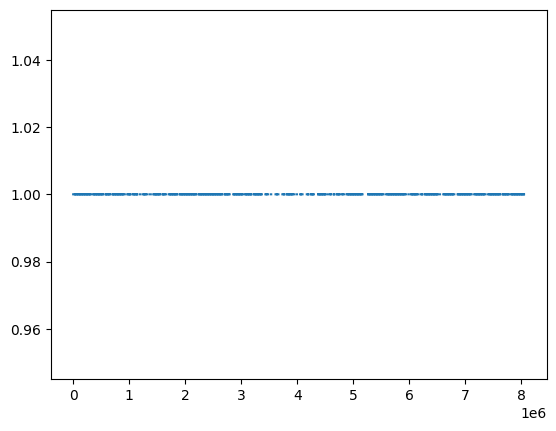

In [105]:
plt.plot(full_mask_3_day)

In [106]:
# Let's compute the true number of nans in the eta variables
N_nans_multiple_gaps = np.sum(np.isnan(full_mask_3_day))

data_w_multi_gaps = nanify_telemetry_variables(data_3_day_sim, full_mask_3_day)

etas_3_day_sim = compute_etas(
    data_3_day_sim, order=order, unit="frequency"
)

etas_w_multi_gaps = compute_etas(
    data_w_multi_gaps, order=order, unit="frequency"
)

2025-07-23 10:43:32,612 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1d1e20>'
2025-07-23 10:43:32,624 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1d1e20>'
2025-07-23 10:43:42,441 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1de270>'
2025-07-23 10:43:42,453 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1de270>'
2025-07-23 10:43:52,764 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1b3ec0>'
2025-07-23 10:43:52,775 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1b3ec0>'
2025-07-23 10:44:03,148 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1b3200>'
2025-07-23 10:44:03,160 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x12f1b3200>'
2025-07-23 10:44:09,694 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x12f1de0f0>'
2025-07-23

<!-- # Try to do the same thing but with TDI X variables for both generations -->

In [107]:

# Compute TDI variables for generation 1 and generation 2
order = 45

TDI_X_no_gaps = compute_factorized_michelson(
    data_3_day_sim, etas=etas_3_day_sim, rot=0, order=order, generation=gen
)
TDI_X_w_gaps = compute_factorized_michelson(
    data_w_multi_gaps, etas=etas_w_multi_gaps, rot=0, order=order, generation=gen
)


2025-07-23 10:47:26,019 - INFO - Initializing combination with components '{'eta_12': [(1, [])], 'eta_21': [(1, ['D_12'])]}'
2025-07-23 10:47:26,020 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x16fba2f90>'
2025-07-23 10:47:26,033 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x16fba2f90>'


2025-07-23 10:47:29,431 - INFO - Initializing combination with components '{'eta_13': [(1, [])], 'eta_31': [(1, ['D_13'])]}'
2025-07-23 10:47:29,431 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x16fba2750>'
2025-07-23 10:47:29,443 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x16fba2750>'
2025-07-23 10:47:32,833 - INFO - Initializing combination with components '{'arm_a': [(1, [])], 'arm_b': [(1, ['D_12', 'D_21'])]}'
2025-07-23 10:47:32,834 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x16fc9d970>'
2025-07-23 10:47:33,526 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x16fc9d970>'
2025-07-23 10:47:36,975 - INFO - Initializing combination with components '{'arm_a': [(1, ['D_13', 'D_31'])], 'arm_b': [(1, [])]}'
2025-07-23 10:47:36,976 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x16fc9d970>'
2025-07-23 10:47:37,635 - INFO - Evaluate combination '<pytdi.c

In [ ]:
from scipy.signal import welch, lombscargle

# Welch PSD for TDI2 X (no gaps)
freq_welch_tdi2_long_sim, psd_welch_tdi2_long_sim = welch(
    TDI_X_no_gaps,
    fs=fs,
    window='hann',
    nperseg=8192,
    noverlap=4096,
    scaling='density'
)

# Remove NaNs from gapped TDI2 X
valid_mask_tdi2 = ~np.isnan(TDI_X_w_gaps)
tdi2_gapped_clean = TDI_X_w_gaps[valid_mask_tdi2]
tdi2_gapped_times = sim_t[valid_mask_tdi2]

# Lomb-Scargle for gapped TDI2 X
nyquist_tdi2 = 0.5 * fs
lowest_freq = np.log10(1/(simlen_multi_gap * dt))  # Corresponds to the length of the simulation
frequencies_ls_tdi2 = np.logspace(lowest_freq, np.log10(nyquist_tdi2), 2000)
angular_frequencies_tdi2 = 2 * np.pi * frequencies_ls_tdi2
pgram_tdi2_gaps = lombscargle(tdi2_gapped_times, tdi2_gapped_clean, angular_frequencies_tdi2, normalize=True)
# Normalise to match Welch scaling
pgram_tdi2_gaps_scaled = pgram_tdi2_gaps * np.var(tdi2_gapped_clean) * len(tdi2_gapped_clean) / fs


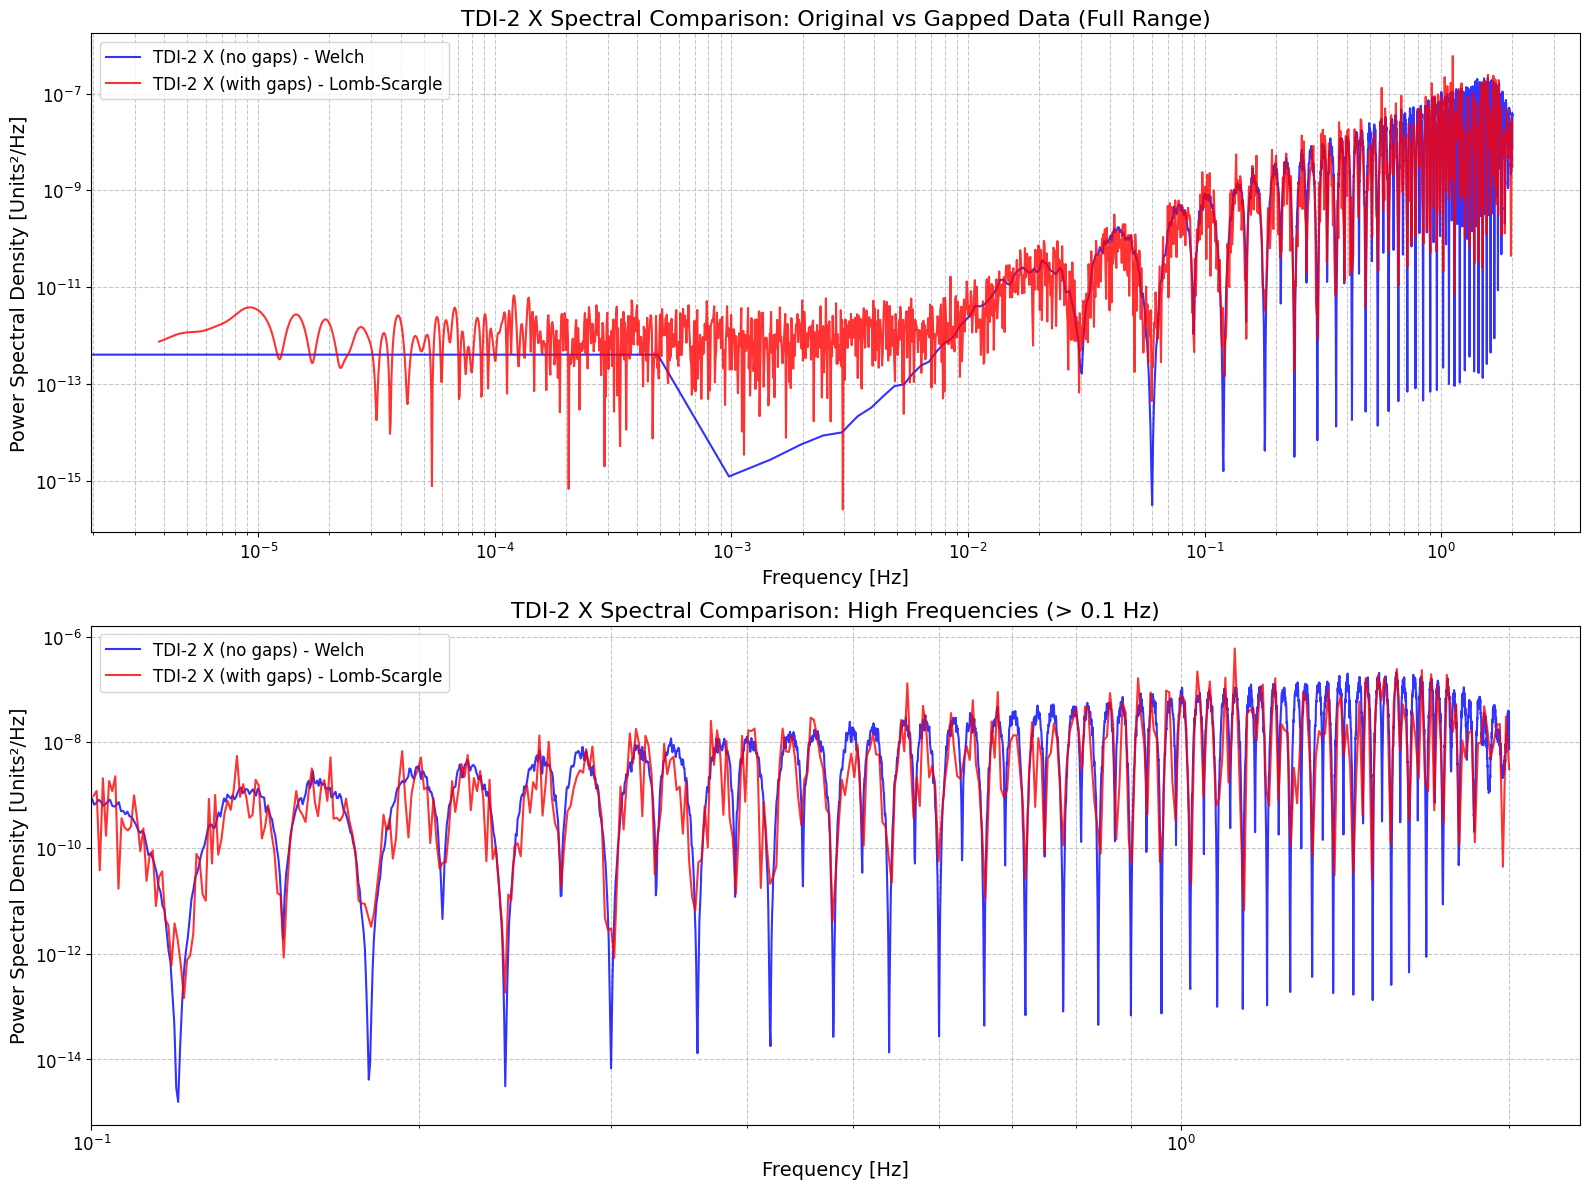


High-Frequency Analysis (> 0.1 Hz):
Welch points above 0.1 Hz: 3892
Lomb-Scargle points above 0.1 Hz: 455
Mean power (Welch, > 0.1 Hz): 2.841394e-08
Mean power (Lomb-Scargle, > 0.1 Hz): 1.543735e-08
High-frequency power ratio (Gapped/Original): 0.5433


In [99]:
# Create comparison plot for TDI-2 X periodograms with high-frequency zoom
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Direct comparison of PSDs for TDI-2 X (full frequency range)
ax1.loglog(freq_welch_tdi2, psd_welch_tdi2, label='TDI-2 X (no gaps) - Welch', 
           linewidth=1.5, alpha=0.8, color='blue')
ax1.loglog(frequencies_ls_tdi2, pgram_tdi2_gaps_scaled, label='TDI-2 X (with gaps) - Lomb-Scargle', 
           linewidth=1.5, alpha=0.8, color='red')
ax1.set_xlabel('Frequency [Hz]', fontsize=14)
ax1.set_ylabel('Power Spectral Density [Units²/Hz]', fontsize=14)
ax1.set_title('TDI-2 X Spectral Comparison: Original vs Gapped Data (Full Range)', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, which="both", linestyle="--", alpha=0.7)
ax1.tick_params(axis="both", which="major", labelsize=12)

# Plot 2: Zoomed view for high frequencies (> 0.1 Hz)
freq_mask_welch = freq_welch_tdi2 > 0.1
freq_mask_ls = frequencies_ls_tdi2 > 0.1

ax2.loglog(freq_welch_tdi2[freq_mask_welch], psd_welch_tdi2[freq_mask_welch], 
           label='TDI-2 X (no gaps) - Welch', linewidth=1.5, alpha=0.8, color='blue')
ax2.loglog(frequencies_ls_tdi2[freq_mask_ls], pgram_tdi2_gaps_scaled[freq_mask_ls], 
           label='TDI-2 X (with gaps) - Lomb-Scargle', linewidth=1.5, alpha=0.8, color='red')
ax2.set_xlabel('Frequency [Hz]', fontsize=14)
ax2.set_ylabel('Power Spectral Density [Units²/Hz]', fontsize=14)
ax2.set_title('TDI-2 X Spectral Comparison: High Frequencies (> 0.1 Hz)', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, which="both", linestyle="--", alpha=0.7)
ax2.tick_params(axis="both", which="major", labelsize=12)
ax2.set_xlim([0.1, None])  # Set minimum frequency to 0.1 Hz

plt.tight_layout()
plt.show()

# Print statistics about high-frequency behavior
print(f"\nHigh-Frequency Analysis (> 0.1 Hz):")
print(f"Welch points above 0.1 Hz: {np.sum(freq_mask_welch)}")
print(f"Lomb-Scargle points above 0.1 Hz: {np.sum(freq_mask_ls)}")

if np.sum(freq_mask_welch) > 0 and np.sum(freq_mask_ls) > 0:
    # Calculate mean power in high-frequency range
    mean_power_welch_hf = np.mean(psd_welch_tdi2[freq_mask_welch])
    mean_power_ls_hf = np.mean(pgram_tdi2_gaps_scaled[freq_mask_ls])
    
    print(f"Mean power (Welch, > 0.1 Hz): {mean_power_welch_hf:.6e}")
    print(f"Mean power (Lomb-Scargle, > 0.1 Hz): {mean_power_ls_hf:.6e}")
    print(f"High-frequency power ratio (Gapped/Original): {mean_power_ls_hf/mean_power_welch_hf:.4f}")

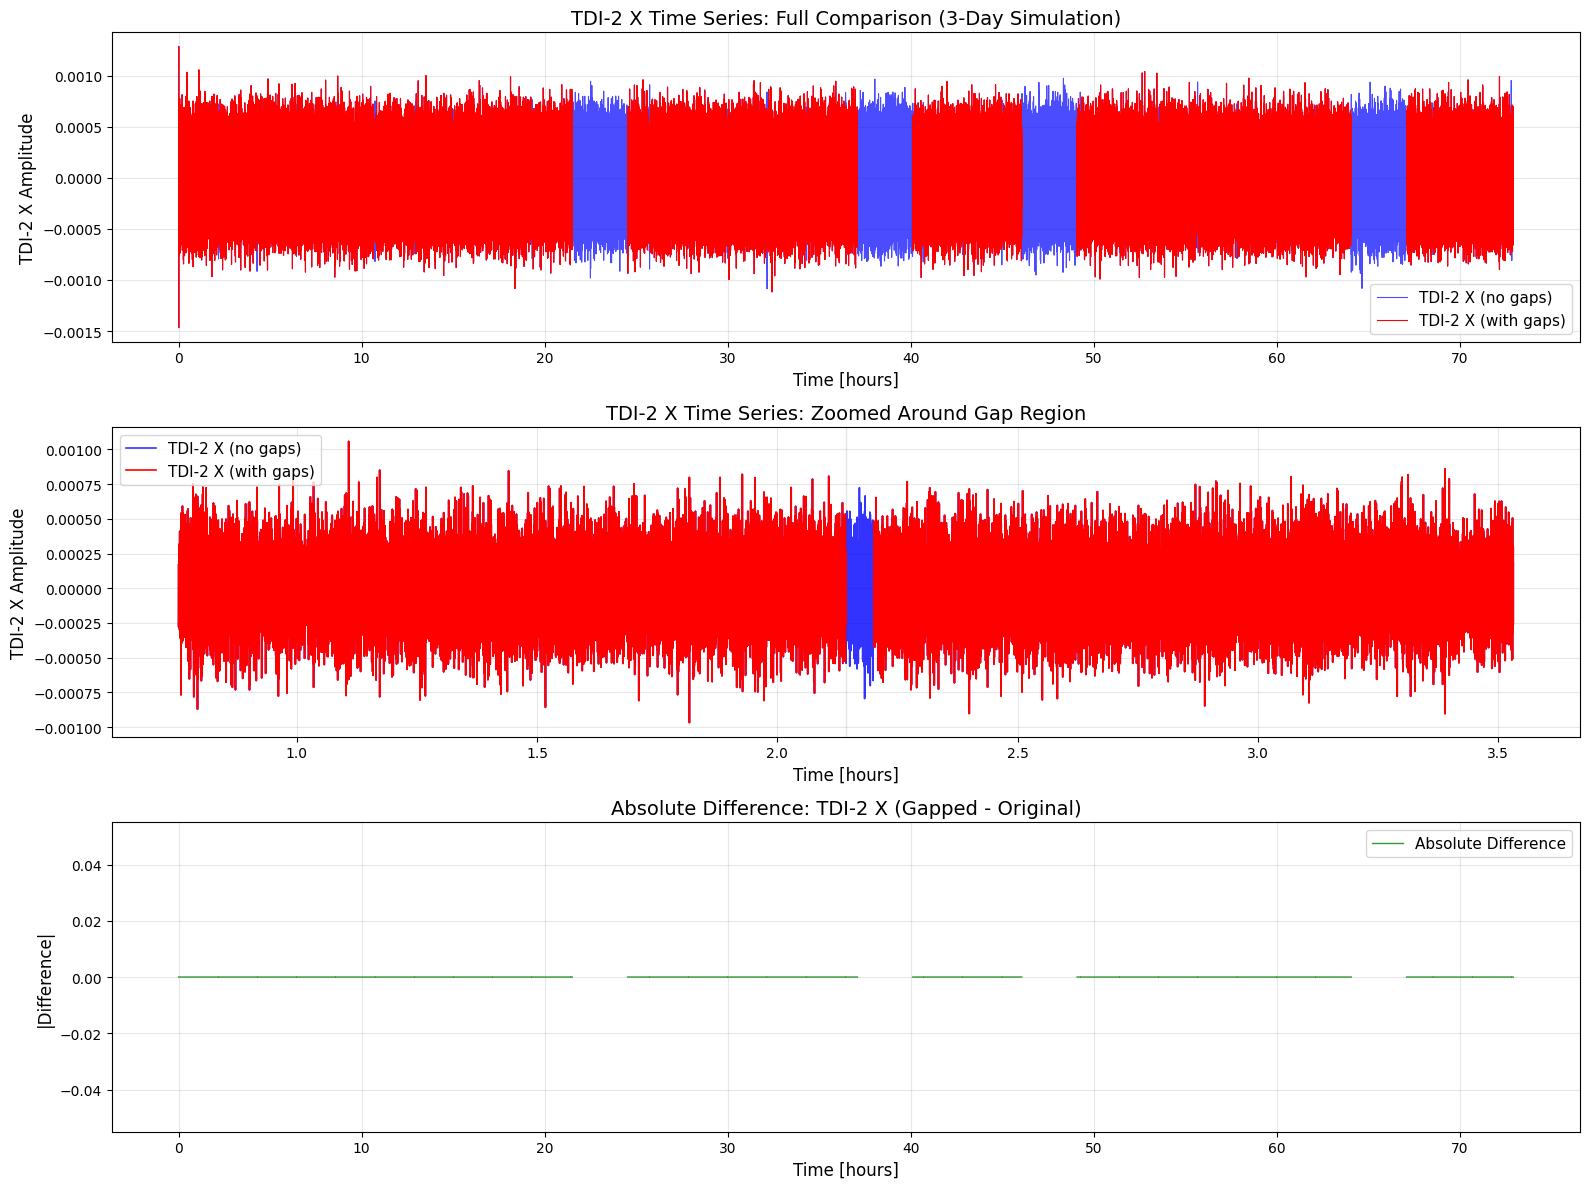


TDI-2 X Time Domain Analysis (3-Day Simulation):
Original TDI-2 X RMS: 2.318514e-04
Gapped TDI-2 X RMS (excluding NaNs): 2.318114e-04
Maximum absolute difference: 0.000000e+00
RMS of difference: 0.000000e+00
Mean absolute difference: 0.000000e+00

Gap Analysis (3-Day Simulation):
Original gap duration: 12.957 hours
TDI-2 gap duration: 13.775 hours
Gap amplification factor: 1.06
RMS difference in non-gap regions: 0.000000e+00

Multiple Gap Statistics:
Total simulation duration: 3.04 days
Percentage of original data lost to gaps: 17.769%
Percentage of TDI-2 data lost to gaps: 18.891%


In [101]:
# Look at the difference of the two TDI expressions (using longer simulation data)

# Plot TDI-2 X time series comparison for the 3-day simulation
fig, axs = plt.subplots(3, 1, figsize=(16, 12))

# Use the longer simulation time vector
sim_t_long = np.arange(0, simlen_multi_gap * dt, dt)

# Find gap locations for zoomed view in the longer simulation
gap_indices = np.where(np.isnan(full_mask_3_day))[0]
if len(gap_indices) > 0:
    # Find the first significant gap for zooming
    gap_starts = np.where(np.diff(np.concatenate(([False], np.isnan(full_mask_3_day)))))[0]
    gap_ends = np.where(np.diff(np.concatenate((np.isnan(full_mask_3_day), [False]))))[0]
    
    # Use the first gap for demonstration
    idx_start_gap = gap_starts[0] if len(gap_starts) > 0 else gap_indices[0]
    idx_end_gap = gap_ends[0] if len(gap_ends) > 0 else gap_indices[-1]
else:
    # Fallback if no gaps found
    idx_start_gap = len(sim_t_long) // 2
    idx_end_gap = idx_start_gap + 1000

# Plot 1: Full time series comparison
axs[0].plot(sim_t_long / 3600, TDI_X_no_gaps[1], label="TDI-2 X (no gaps)", 
            alpha=0.7, linewidth=0.8, color='blue')
axs[0].plot(sim_t_long / 3600, TDI_X_gaps[1], label="TDI-2 X (with gaps)", 
            alpha=1.0, linewidth=0.8, color='red')
axs[0].set_ylabel('TDI-2 X Amplitude', fontsize=12)
axs[0].set_xlabel('Time [hours]', fontsize=12)
axs[0].set_title('TDI-2 X Time Series: Full Comparison (3-Day Simulation)', fontsize=14)
axs[0].legend(fontsize=11)
axs[0].grid(True, alpha=0.3)

# Plot 2: Zoomed view around the gap
zoom_window = 20000  # samples around gap (larger for 3-day sim)
start_zoom = max(0, idx_start_gap - zoom_window)
end_zoom = min(len(sim_t_long), idx_end_gap + zoom_window)

axs[1].plot(sim_t_long[start_zoom:end_zoom] / 3600, 
            TDI_X_no_gaps[1][start_zoom:end_zoom], 
            label="TDI-2 X (no gaps)", alpha=0.8, linewidth=1.2, color='blue')
axs[1].plot(sim_t_long[start_zoom:end_zoom] / 3600, 
            TDI_X_gaps[1][start_zoom:end_zoom], 
            label="TDI-2 X (with gaps)", alpha=1.0, linewidth=1.2, color='red')
axs[1].set_ylabel('TDI-2 X Amplitude', fontsize=12)
axs[1].set_xlabel('Time [hours]', fontsize=12)
axs[1].set_title('TDI-2 X Time Series: Zoomed Around Gap Region', fontsize=14)
axs[1].legend(fontsize=11)
axs[1].grid(True, alpha=0.3)

# Highlight the original gap region
gap_start_time = sim_t_long[idx_start_gap] / 3600
gap_end_time = sim_t_long[idx_end_gap] / 3600
axs[1].axvspan(gap_start_time, gap_end_time, alpha=0.2, color='gray', 
               label='Original gap region')

# Plot 3: Absolute difference between the two
tdi_diff_long = np.abs(TDI_X_gaps[1] - TDI_X_no_gaps[1])
axs[2].plot(sim_t_long / 3600, tdi_diff_long, label="Absolute Difference", 
            color="green", linewidth=1.0, alpha=0.8)
axs[2].set_ylabel('|Difference|', fontsize=12)
axs[2].set_xlabel('Time [hours]', fontsize=12)
axs[2].set_title('Absolute Difference: TDI-2 X (Gapped - Original)', fontsize=14)
axs[2].legend(fontsize=11)
axs[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics about the differences
print(f"\nTDI-2 X Time Domain Analysis (3-Day Simulation):")
print(f"Original TDI-2 X RMS: {np.sqrt(np.mean(TDI_X_no_gaps[1]**2)):.6e}")
print(f"Gapped TDI-2 X RMS (excluding NaNs): {np.sqrt(np.nanmean(TDI_X_gaps[1]**2)):.6e}")
print(f"Maximum absolute difference: {np.nanmax(tdi_diff_long):.6e}")
print(f"RMS of difference: {np.sqrt(np.nanmean(tdi_diff_long**2)):.6e}")
print(f"Mean absolute difference: {np.nanmean(tdi_diff_long):.6e}")

# Gap statistics for the 3-day simulation
print(f"\nGap Analysis (3-Day Simulation):")
print(f"Original gap duration: {np.sum(np.isnan(full_mask_3_day)) * dt / 3600:.3f} hours")
print(f"TDI-2 gap duration: {np.sum(np.isnan(TDI_X_gaps[1])) * dt / 3600:.3f} hours")
print(f"Gap amplification factor: {np.sum(np.isnan(TDI_X_gaps[1])) / np.sum(np.isnan(full_mask_3_day)):.2f}")

# Check if there are non-zero differences outside the gap regions
non_gap_mask_long = ~np.isnan(TDI_X_gaps[1]) & ~np.isnan(TDI_X_no_gaps[1])
non_gap_diff_rms_long = np.sqrt(np.mean(tdi_diff_long[non_gap_mask_long]**2))
print(f"RMS difference in non-gap regions: {non_gap_diff_rms_long:.6e}")

# Additional statistics about the multiple gaps
print(f"\nMultiple Gap Statistics:")
print(f"Total simulation duration: {simlen_multi_gap * dt / 3600 / 24:.2f} days")
print(f"Percentage of original data lost to gaps: {100 * np.sum(np.isnan(full_mask_3_day)) / len(full_mask_3_day):.3f}%")
print(f"Percentage of TDI-2 data lost to gaps: {100 * np.sum(np.isnan(TDI_X_gaps[1])) / len(TDI_X_gaps[1]):.3f}%")